In [1]:
import numpy as np
import pandas as pd
import open3d as o3d
import pymeshlab as pyml
import time 
import os
import trimesh

from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler

import matplotlib.pyplot as plt
import seaborn as sns



from plyfile import PlyData, PlyElement


In [2]:
pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_columns", 2000)
pd.set_option("display.max_colwidth", 256)

In [3]:
%matplotlib inline
sns.set(rc={'figure.figsize':(8,6)})


In [4]:
os.chdir("D:\\Workspace\\Python\\Thesis Data\\")

In [5]:
INPUT_PATH = os.getcwd()+'\\Save data\\Processed_data'
OUTPUT_TEMP_PATH = os.getcwd()+'\\Save data\\Processed_data\\Output_temp'

INPUT_TEMP_PATH = os.getcwd()+'\\Save data\\Processed_data\\Output_temp'
OUTPUT_PATH = os.getcwd()+'\\Save data\\Processed_data\\Output'
OUTPUT_PCA_PATH = os.getcwd()+'\\Save data\\Processed_data\\Output\\PCA'

In [6]:
patient_id_list = '2_BC	3_BC	4_BC	5_BM	6_BM	7_BP	8_BP	9_KBW	10_SUM	11_DHM	12_GAW	13_PMM	14_TR	15_TR	16_TR	18_EM	19_EM	20_EM	21_FA	22_FA	23_HJ	24_HJ	25_HM	26_HM	27_HM	28_JM	29_JM	30_JM	31_JM	32_JM	33_KBB	34_KBB	35_KBB	36_KBB	37_KBB	38_KBB	39_KBB	40_KBB	41_KBB	42_KBB	43_KBB	44_AC	45_AC	46_LE	47_LE	48_LE	49_LE	50_LE	51_LE	52_LE	53_LS	54_MR	55_MR	56_WA	57_SF	58_SI	59_SI	1_AK	60_BL	61_BN	62_CA	63_CA	64_CA	65_FU	66_GI	67_HC	68_HD	69_HI	70_HI	71_HRA	72_HRA	73_HS	74_HS	75_IS	76_JM	77_KA	78_KB	79_KBB	80_KBB	81_KBB	82_KBB	83_KBB	84_KE	85_KG	86_KI	87_KJ	88_KR	89_LE	90_BMW	91_LS	92_MAS	93_MAS	94_MAS	95_MAS	96_MAS	97_MD	98_MJ	99_MM	100_MR	101_MR	102_OC	103_PA	104_PH	105_RS	106_RU	107_SA	108_SB	109_SG	110_SK	111_SK	112_SM	113_SN	114_SR	115_SR	116_SR	117_TI	118_TI	119_TI	120_TM	121_TR	122_TR	123_TR	124_VA	125_VT	126_WD	127_WW	128_WW	129_ZK	130_ZK	131_ZK'
patient_id_list = patient_id_list.split()
patient_id_list[:5]

['2_BC', '3_BC', '4_BC', '5_BM', '6_BM']

In [7]:
patient_id_list_new =  '2_BC	3_BC	4_BC	5_BM	6_BM	7_BP	8_BP	9_KBW	10_SUM	11_DHM	12_GAW	13_PMM	14_TR	15_TR	16_TR	18_EM	19_EM	20_EM	21_FA	22_FA	23_HJ	24_HJ	25_HM	26_HM	27_HM	28_JM	29_JM	30_JM	31_JM	32_JM	33_KBB	34_KBB	35_KBB	36_KBB	37_KBB	38_KBB	39_KBB	40_KBB	41_KBB	42_KBB	43_KBB	44_AC	45_AC	46_LE	47_LE	48_LE	49_LE	50_LE	51_LE	52_LE	53_LS	54_MR	55_MR	56_WA	57_SF	58_SI	59_SI	1_AK	60_BL	61_BN	62_CA	63_CA	64_CA	65_FU	66_GI	67_HC	68_HD	69_HI	70_HI	71_HRA	72_HRA	73_HS	74_HS	75_IS	76_JM	77_KA	78_KB	79_KBB	80_KBB	81_KBB	82_KBB	83_KBB	84_KE	85_KG	86_KI	87_KJ	88_KR	89_LE	90_BMW	91_LS	92_MAS	93_MAS	94_MAS	95_MAS	96_MAS	97_MD	98_MJ	99_MM	100_MR	101_MR	102_OC	103_PA	104_PH	105_RS	106_RU	107_SA	108_SB	109_SG	110_SK	111_SK	112_SM	113_SN	114_SR	115_SR	116_SR	117_TI	118_TI	119_TI	120_TM	121_TR	122_TR	123_TR	124_VA	125_VT	126_WD	127_WW	128_WW	129_ZK	130_ZK	131_ZK'
patient_id_list_new = patient_id_list_new.split()
patient_id_list_new[:5]

['2_BC', '3_BC', '4_BC', '5_BM', '6_BM']

In [8]:
ORIGINAL_FILENAME = "_PLY0.ply"
WSS_FILENAME = "_WSS.csv"
WSS_DOWN_FILENME = "_WSS_down.csv"
CURV_FILENAME = "_curv_down.csv"

PYMESH_FILENAME = "_pymesh.ply"
DESC_1_FILENAME = "_fpfh.ply"
DESC_2_FILENAME = "_shot.ply"

RADIUS_SEARCH = 0.00024
RADIUS = RADIUS_SEARCH * 0.6

OUTPUT_FILENAME = "_output.ply"
PCA_FILENAME = "_pca.ply"
os.path.join(OUTPUT_TEMP_PATH,f"{'3_BC'}{PCA_FILENAME}")

'D:\\Workspace\\Python\\Thesis Data\\Save data\\Processed_data\\Output_temp\\3_BC_pca.ply'

In [9]:
print (f"TOTAL FILES TO BE PROCESSED: {len(patient_id_list)}")

TOTAL FILES TO BE PROCESSED: 130


# Based on WSS

## 1.1 WSS for downsampled files

In [13]:
def scale_data(col: pd.Series,scaler) -> pd.Series:
    """
    Scale a column
    """
    X = col.values.reshape(-1, 1).copy()
    scaled_array = scaler.fit_transform(X)

    scaled_column = pd.Series(scaled_array.tolist()).explode()

    return scaled_column

In [14]:
wss_columns = ['original_points','sampled_points','wss_mean','wss_median','wss_std','wss_min','wss_max',]

wss_eda = pd.DataFrame(index=patient_id_list, columns = wss_columns )
wss_eda_scaled = pd.DataFrame(index=patient_id_list, columns = wss_columns )

if not wss_eda.empty and wss_eda_scaled.empty :
    del(wss_eda)
    del(wss_eda_scaled)
    

wss_eda.head(2)

,original_points,sampled_points,wss_mean,wss_median,wss_std,wss_min,wss_max
2_BC,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3_BC,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:

for PATIENT_ID in patient_id_list:

    
    df_wss= pd.read_csv(os.path.join(INPUT_TEMP_PATH,f"{PATIENT_ID}{WSS_DOWN_FILENME}"))
    
    #Scale the data
    min_max_scaler = MinMaxScaler() 
    df_wss["WSS_scaled"] = scale_data(df_wss["WSS"],min_max_scaler)
    
    
    wss_eda.loc[PATIENT_ID] = [np.nan, df_wss.shape[0] , 
                               np.mean(df_wss.WSS), np.median(df_wss.WSS), np.std(df_wss.WSS), 
                               np.min(df_wss.WSS), np.max(df_wss.WSS)
                         ]
    wss_eda_scaled.loc[PATIENT_ID] = [np.nan, df_wss.shape[0],
                                      np.mean(df_wss.WSS_scaled), np.median(df_wss.WSS_scaled), np.std(df_wss.WSS_scaled), 
                                      np.min(df_wss.WSS_scaled), np.max(df_wss.WSS_scaled)
                         ]
wss_eda = wss_eda.infer_objects()
wss_eda_scaled = wss_eda_scaled.infer_objects()

wss_eda.head(2)

,original_points,sampled_points,wss_mean,wss_median,wss_std,wss_min,wss_max
2_BC,NaN,15307,2.490443,2.128127,2.100096,0.000186,15.912992
3_BC,NaN,15271,7.490731,7.269658,4.003876,0.230612,24.304548


In [16]:
wss_eda.describe(percentiles = np.linspace(0.0,1.0,10))

,original_points,sampled_points,wss_mean,wss_median,wss_std,wss_min,wss_max
count,0.0,130.000000,130.000000,130.000000,130.000000,1.300000e+02,130.000000
mean,NaN,15306.069231,15.484795,12.569344,12.919276,2.845403e-01,85.027073
std,NaN,94.365871,16.519139,12.942150,15.880039,3.954968e-01,91.916721
min,NaN,15112.000000,2.490443,0.971145,1.862863,3.600000e-07,12.869083
0%,NaN,15112.000000,2.490443,0.971145,1.862863,3.600000e-07,12.869083
11.1%,NaN,15185.666667,4.979878,3.490029,3.930166,1.206893e-02,27.083345
22.2%,NaN,15245.333333,7.261879,5.819152,5.642950,5.129066e-02,37.447340
33.3%,NaN,15268.000000,8.439875,7.019630,6.928952,7.915948e-02,45.003658
44.4%,NaN,15289.333333,9.881478,8.165406,8.899347,1.243174e-01,59.225662
50%,NaN,15301.000000,11.470729,9.078912,9.739205,1.498490e-01,63.049647


In [17]:
wss_eda_scaled.describe(percentiles = np.linspace(0.0,1.0,10))

,original_points,sampled_points,wss_mean,wss_median,wss_std,wss_min,wss_max
count,0.0,130.000000,130.000000,130.000000,130.000000,130.0,1.300000e+02
mean,NaN,15306.069231,0.190047,0.157871,0.153363,0.0,1.000000e+00
std,NaN,94.365871,0.058078,0.067940,0.033383,0.0,1.139947e-16
min,NaN,15112.000000,0.068602,0.020580,0.073624,0.0,1.000000e+00
0%,NaN,15112.000000,0.068602,0.020580,0.073624,0.0,1.000000e+00
11.1%,NaN,15185.666667,0.125489,0.082932,0.111485,0.0,1.000000e+00
22.2%,NaN,15245.333333,0.147104,0.109481,0.123341,0.0,1.000000e+00
33.3%,NaN,15268.000000,0.161079,0.127302,0.136421,0.0,1.000000e+00
44.4%,NaN,15289.333333,0.174724,0.139185,0.147434,0.0,1.000000e+00
50%,NaN,15301.000000,0.182438,0.146722,0.155938,0.0,1.000000e+00


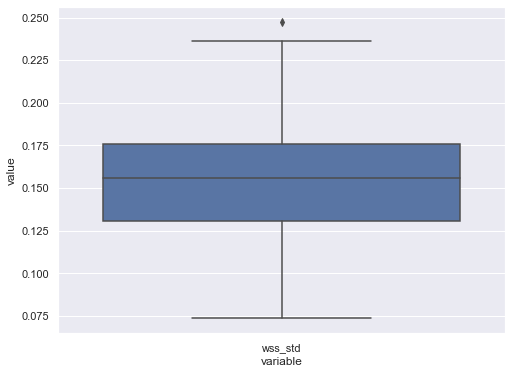

In [25]:
sns.boxplot(x="variable", y="value", data=pd.melt(wss_eda_scaled.iloc[:,4:5]))

plt.show()

## 1.2 WSS and division into classes
What percentage of points are in each classes

### num_parts_to_segment = 5

In [14]:
def scale_data(col: pd.Series,scaler) -> pd.Series:
    """
    Scale a column
    """
    X = col.values.reshape(-1, 1).copy()
    scaled_array = scaler.fit_transform(X)

    scaled_column = pd.Series(scaled_array.tolist()).explode()

    return scaled_column

In [66]:
num_parts_to_segment = 5


if num_parts_to_segment == 5:
    wss_columns = ['original_points','sampled_points','down_percent','Class_0','Class_1','Class_2','Class_3','Class_4']
elif num_parts_to_segment == 3:
    wss_columns = ['original_points','sampled_points','down_percent','Class_0','Class_1','Class_2']
elif num_parts_to_segment == 7:
    wss_columns = ['original_points','sampled_points','down_percent','Class_0','Class_1','Class_2','Class_3','Class_4','Class_5','Class_6']

wss_eda = pd.DataFrame(index=patient_id_list, columns = wss_columns )
wss_eda_scaled = pd.DataFrame(index=patient_id_list, columns = wss_columns )

if not wss_eda.empty and wss_eda_scaled.empty :
    del(wss_eda)
    del(wss_eda_scaled)
    
wss_eda.head(2)

,original_points,sampled_points,down_percent,Class_0,Class_1,Class_2,Class_3,Class_4
2_BC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3_BC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [67]:
wss_eda_scaled.head(2)

,original_points,sampled_points,down_percent,Class_0,Class_1,Class_2,Class_3,Class_4
2_BC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3_BC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [68]:

for PATIENT_ID in patient_id_list:

    df_wss= pd.read_csv(os.path.join(INPUT_PATH,f"{PATIENT_ID}{WSS_FILENAME}"))
    df_wss_scaled= pd.read_csv(os.path.join(INPUT_TEMP_PATH,f"{PATIENT_ID}{WSS_DOWN_FILENME}"))

    #Scale the data
    min_max_scaler = MinMaxScaler() 
    df_wss["WSS"] = scale_data(df_wss["WSS"],min_max_scaler)
    df_wss_scaled["WSS"] = scale_data(df_wss_scaled["WSS"],min_max_scaler)

    
    # Divide into classes
    df_wss["WSS"] = pd.cut(df_wss["WSS"],
                           bins=np.linspace(0, 1, num_parts_to_segment + 1),
                           labels=np.arange(0, num_parts_to_segment),
                          )
    
    df_wss_scaled["WSS"] = pd.cut( df_wss_scaled["WSS"],
                                  bins=np.linspace(0, 1, num_parts_to_segment + 1),
                                  labels=np.arange(0, num_parts_to_segment),
                                 )
    
    if num_parts_to_segment == 5:
        wss_eda.loc[PATIENT_ID] = [df_wss.shape[0], df_wss_scaled.shape[0], 
                                   np.round((df_wss_scaled.shape[0]/df_wss.shape[0])*100,4),
                                   np.round((df_wss.WSS.value_counts()[0]/df_wss.shape[0])*100,4),
                                   np.round((df_wss.WSS.value_counts()[1]/df_wss.shape[0])*100,4),
                                   np.round((df_wss.WSS.value_counts()[2]/df_wss.shape[0])*100,4),
                                   np.round((df_wss.WSS.value_counts()[3]/df_wss.shape[0])*100,4),
                                   np.round((df_wss.WSS.value_counts()[4]/df_wss.shape[0])*100,4),
                                  ]
        
        wss_eda_scaled.loc[PATIENT_ID] = [df_wss.shape[0], df_wss_scaled.shape[0],
                                          np.round((df_wss_scaled.shape[0]/df_wss.shape[0])*100,4),
                                          np.round((df_wss_scaled.WSS.value_counts()[0]/df_wss_scaled.shape[0])*100,4),
                                          np.round((df_wss_scaled.WSS.value_counts()[1]/df_wss_scaled.shape[0])*100,4),
                                          np.round((df_wss_scaled.WSS.value_counts()[2]/df_wss_scaled.shape[0])*100,4),
                                          np.round((df_wss_scaled.WSS.value_counts()[3]/df_wss_scaled.shape[0])*100,4),
                                          np.round((df_wss_scaled.WSS.value_counts()[4]/df_wss_scaled.shape[0])*100,4),
                                         ]
    elif num_parts_to_segment == 3:
        wss_eda.loc[PATIENT_ID] = [df_wss.shape[0], df_wss_scaled.shape[0],
                                   np.round((df_wss_scaled.shape[0]/df_wss.shape[0])*100,4),
                                   np.round(df_wss.WSS.value_counts()[0]/df_wss.shape[0]*100,4),
                                   np.round(df_wss.WSS.value_counts()[1]/df_wss.shape[0]*100,4),
                                   np.round(df_wss.WSS.value_counts()[2]/df_wss.shape[0]*100,4),
                                  ]
        wss_eda_scaled.loc[PATIENT_ID] = [df_wss.shape[0], df_wss_scaled.shape[0],
                                          np.round((df_wss_scaled.shape[0]/df_wss.shape[0])*100,4),
                                          np.round((df_wss_scaled.WSS.value_counts()[0]/df_wss_scaled.shape[0])*100,4),
                                          np.round((df_wss_scaled.WSS.value_counts()[1]/df_wss_scaled.shape[0])*100,4),
                                          np.round((df_wss_scaled.WSS.value_counts()[2]/df_wss_scaled.shape[0])*100,4),
                                         ]
    elif num_parts_to_segment == 7:
        wss_eda.loc[PATIENT_ID] = [df_wss.shape[0], df_wss_scaled.shape[0],
                                   np.round((df_wss_scaled.shape[0]/df_wss.shape[0])*100,4),
                                   np.round(df_wss.WSS.value_counts()[0]/df_wss.shape[0]*100,4),
                                   np.round(df_wss.WSS.value_counts()[1]/df_wss.shape[0]*100,4),
                                   np.round(df_wss.WSS.value_counts()[2]/df_wss.shape[0]*100,4),
                                   np.round(df_wss.WSS.value_counts()[3]/df_wss.shape[0]*100,4),
                                   np.round(df_wss.WSS.value_counts()[4]/df_wss.shape[0]*100,4),
                                   np.round(df_wss.WSS.value_counts()[5]/df_wss.shape[0]*100,4),
                                   np.round(df_wss.WSS.value_counts()[6]/df_wss.shape[0]*100,4),
                                  ]
        wss_eda_scaled.loc[PATIENT_ID] = [df_wss.shape[0], df_wss_scaled.shape[0],
                                          np.round((df_wss_scaled.shape[0]/df_wss.shape[0])*100,4),
                                          np.round((df_wss_scaled.WSS.value_counts()[0]/df_wss_scaled.shape[0])*100,4),
                                          np.round((df_wss_scaled.WSS.value_counts()[1]/df_wss_scaled.shape[0])*100,4),
                                          np.round((df_wss_scaled.WSS.value_counts()[2]/df_wss_scaled.shape[0])*100,4),
                                          np.round((df_wss_scaled.WSS.value_counts()[3]/df_wss_scaled.shape[0])*100,4),
                                          np.round((df_wss_scaled.WSS.value_counts()[4]/df_wss_scaled.shape[0])*100,4),
                                          np.round((df_wss_scaled.WSS.value_counts()[5]/df_wss_scaled.shape[0])*100,4),
                                          np.round((df_wss_scaled.WSS.value_counts()[6]/df_wss_scaled.shape[0])*100,4),
                                         ]
        
wss_eda = wss_eda.infer_objects()
wss_eda_scaled = wss_eda_scaled.infer_objects()

wss_eda.head(2)

,original_points,sampled_points,down_percent,Class_0,Class_1,Class_2,Class_3,Class_4
2_BC,77127,15307,19.8465,79.7892,17.0615,2.5866,0.4707,0.0908
3_BC,28274,15271,54.0108,46.8735,43.2977,8.9906,0.7746,0.0601


In [69]:
wss_eda

,original_points,sampled_points,down_percent,Class_0,Class_1,Class_2,Class_3,Class_4
2_BC,77127,15307,19.8465,79.7892,17.0615,2.5866,0.4707,0.0908
3_BC,28274,15271,54.0108,46.8735,43.2977,8.9906,0.7746,0.0601
4_BC,22604,15223,67.3465,65.5857,19.7045,13.3870,1.0396,0.2787
5_BM,95358,15366,16.1140,82.6873,15.7984,1.2783,0.1940,0.0409
6_BM,20744,15154,73.0524,71.7171,16.3951,8.5953,2.2754,1.0123
7_BP,68120,15286,22.4398,60.5637,35.9043,3.3456,0.1674,0.0176
8_BP,88042,15376,17.4644,83.1331,15.8152,0.8257,0.1749,0.0500
9_KBW,79622,15393,19.3326,45.9923,39.4288,12.5970,1.6955,0.2851
10_SUM,70856,15155,21.3884,64.4462,29.2565,5.2854,0.9230,0.0875
11_DHM,76754,15304,19.9390,91.3021,8.0817,0.4091,0.1485,0.0560


In [70]:
wss_eda_scaled

,original_points,sampled_points,down_percent,Class_0,Class_1,Class_2,Class_3,Class_4
2_BC,77127,15307,19.8465,69.6087,25.1127,4.7429,0.4508,0.0784
3_BC,28274,15271,54.0108,44.3979,29.1926,22.0287,3.7653,0.6024
4_BC,22604,15223,67.3465,63.9230,20.6004,14.2613,0.9328,0.2759
5_BM,95358,15366,16.1140,68.1830,25.4263,5.1673,0.8395,0.3775
6_BM,20744,15154,73.0524,70.1135,16.6887,9.4431,2.6000,1.1482
7_BP,68120,15286,22.4398,41.2665,26.1023,25.4481,6.4307,0.7458
8_BP,88042,15376,17.4644,69.8036,27.6600,1.9381,0.4227,0.1691
9_KBW,79622,15393,19.3326,40.6548,36.1073,17.4755,4.7164,1.0394
10_SUM,70856,15155,21.3884,56.0607,30.6631,10.1749,2.6658,0.4289
11_DHM,76754,15304,19.9390,83.2985,14.8981,1.1827,0.4639,0.1503


In [81]:
wss_eda_scaled.describe(percentiles = np.linspace(0.0,1.0,10))

,original_points,sampled_points,down_percent,Class_0,Class_1,Class_2,Class_3,Class_4
count,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000
mean,66639.869231,15306.069231,26.184475,62.766219,26.232883,8.137533,2.286140,0.568935
std,22043.015602,94.365871,11.410649,13.889047,8.779858,6.095561,2.198614,0.595373
min,20744.000000,15112.000000,10.251200,33.292300,2.734800,0.385100,0.117500,0.078400
0%,20744.000000,15112.000000,10.251200,33.292300,2.734800,0.385100,0.117500,0.078400
11.1%,42183.000000,15185.666667,17.286100,44.511467,14.759767,1.797867,0.450733,0.158767
22.2%,49697.000000,15245.333333,19.046767,51.524300,19.189500,2.903700,0.626267,0.230700
33.3%,56936.000000,15268.000000,20.147300,55.362300,23.370000,4.496500,0.875400,0.293300
44.4%,62434.333333,15289.333333,21.715267,60.374167,25.780100,6.151767,1.444800,0.373767
50%,65068.500000,15301.000000,23.463600,62.318650,26.823250,7.058300,1.693150,0.405550


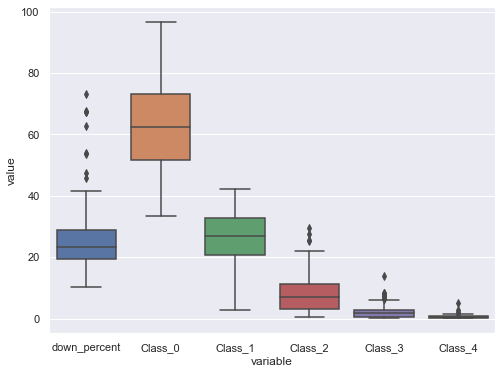

In [71]:
sns.boxplot(x="variable", y="value", data=pd.melt(wss_eda_scaled.iloc[:,2:]))

plt.show()

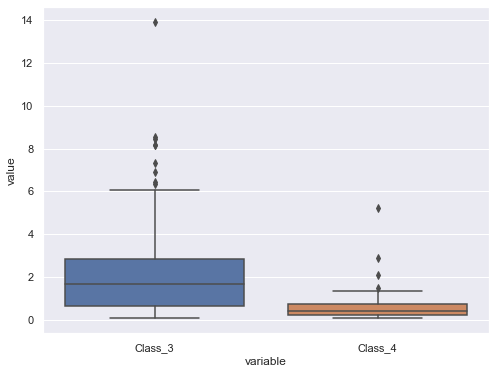

In [126]:
sns.boxplot(x="variable", y="value", data=pd.melt(wss_eda_scaled.iloc[:,6:8]))

plt.show()

In [101]:
def calc_quantiles(df,Q_ratio):
    Q1 = df.quantile(0.25) 
    Q2 = df.quantile(0.50) 
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    Q_min = Q1 - Q_ratio*IQR
    Q_max = Q3 + Q_ratio*IQR
    return Q_min,Q1,Q2,Q3,IQR,Q_max

In [113]:
Q_min,Q1,Q2,Q3,IQR,Q_max = calc_quantiles(wss_eda_scaled,1.2)

In [114]:
Q_min.iloc[7], Q_max.iloc[7]

(-0.342935, 1.315585)

In [115]:
wss_eda_scaled.query("Class_4 > 1.31").index.values

array(['20_EM', '23_HJ', '24_HJ', '59_SI', '70_HI', '85_KG', '117_TI',
       '125_VT'], dtype=object)

In [116]:
wss_eda_scaled.query("Class_4 > 1.31")
#val,train,train,val,train,test,test,val(old test)

,original_points,sampled_points,down_percent,Class_0,Class_1,Class_2,Class_3,Class_4
20_EM,33196,15239,45.9061,73.4891,15.8409,6.4637,2.7167,1.4830
23_HJ,101882,15427,15.1420,33.2923,31.2374,16.3480,13.8977,5.2181
24_HJ,81556,15407,18.8913,38.0671,35.9317,18.6928,5.9259,1.3760
59_SI,82730,15149,18.3114,55.9311,18.9121,17.4203,6.3569,1.3730
70_HI,88923,15322,17.2306,64.8936,25.0489,4.5294,3.4395,2.0820
85_KG,53114,15270,28.7495,53.1500,25.6385,9.8494,8.4545,2.8946
117_TI,22497,15199,67.5601,51.3981,29.2585,12.4482,5.5135,1.3751
125_VT,56936,15242,26.7704,57.6434,17.1237,15.7722,8.1420,1.3122


In [121]:
Q_min,Q1,Q2,Q3,IQR,Q_max = calc_quantiles(wss_eda_scaled,1.5)
Q_min.iloc[6], Q_max.iloc[6]

(-2.6246125000000005, 6.1478875)

In [122]:
wss_eda_scaled.query("Class_3 > 6.1")
#train, train, train, val,train,test,val(old test),val,train

,original_points,sampled_points,down_percent,Class_0,Class_1,Class_2,Class_3,Class_4
7_BP,68120,15286,22.4398,41.2665,26.1023,25.4481,6.4307,0.7458
23_HJ,101882,15427,15.1420,33.2923,31.2374,16.3480,13.8977,5.2181
47_LE,55887,15267,27.3176,40.1716,32.4884,18.1175,8.1745,1.0349
59_SI,82730,15149,18.3114,55.9311,18.9121,17.4203,6.3569,1.3730
64_CA,59919,15244,25.4410,52.5977,27.0467,12.2409,6.9273,1.1808
85_KG,53114,15270,28.7495,53.1500,25.6385,9.8494,8.4545,2.8946
125_VT,56936,15242,26.7704,57.6434,17.1237,15.7722,8.1420,1.3122
128_WW,28227,15182,53.7854,50.8563,25.7476,15.1561,7.3179,0.9156
131_ZK,40806,15160,37.1514,43.4499,28.6082,18.2916,8.5224,1.1214


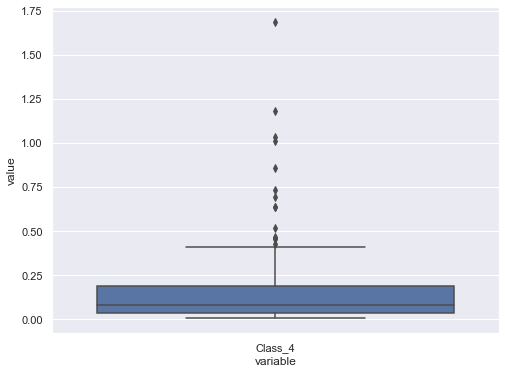

In [127]:
sns.boxplot(x="variable", y="value", data=pd.melt(wss_eda.iloc[:,7:8]))

plt.show()

In [131]:
Q_min,Q1,Q2,Q3,IQR,Q_max = calc_quantiles(wss_eda,1.2)
Q_min.iloc[6], Q_max.iloc[6], Q_min.iloc[7], Q_max.iloc[7]

(-1.084485, 2.48271, -0.15031999999999998, 0.37192)

In [132]:
wss_eda.query("Class_4 > 0.37")

,original_points,sampled_points,down_percent,Class_0,Class_1,Class_2,Class_3,Class_4
6_BM,20744,15154,73.0524,71.7171,16.3951,8.5953,2.2754,1.0123
14_TR,81206,15458,19.0355,63.5889,27.8699,6.5500,1.4740,0.5160
18_EM,64337,15175,23.5867,62.8627,23.7872,10.2973,2.4154,0.6357
20_EM,33196,15239,45.9061,77.2412,13.9836,5.4856,2.4250,0.8585
23_HJ,101882,15427,15.1420,35.5931,34.4860,15.5356,12.6961,1.6872
24_HJ,81556,15407,18.8913,44.8011,36.3468,15.7401,2.6988,0.4120
47_LE,55887,15267,27.3176,45.1608,35.8599,14.2269,4.2926,0.4581
48_LE,42493,15174,35.7094,52.7099,33.7114,11.8231,1.2920,0.4613
59_SI,82730,15149,18.3114,64.5703,18.9943,11.9703,3.7302,0.7337
64_CA,59919,15244,25.4410,58.5691,25.8566,10.1988,4.7347,0.6392


In [7]:
l =  ['102_OC', '27_HM', '113_SN','101_MR','48_LE','4_BC',
         '91_LS', '32_JM',  '67_HC','130_ZK', '55_MR','97_MD', 
         '122_TR', '124_VA', '120_TM', '31_JM','109_SG','89_LE', 
         '75_IS', '69_HI', '78_KB','73_HS', '126_WD','80_KBB','35_KBB', '30_JM',
         '26_HM', '118_TI','105_RS','15_TR','93_MAS',
         '106_RU', '123_TR', '16_TR', '61_BN', '50_LE','68_HD',
         '110_SK','111_SK','86_KI', '108_SB', '2_BC', '3_BC', '10_SUM', 
         '42_KBB','114_SR', '115_SR','41_KBB','76_JM','13_PMM','14_TR','40_KBB',
         '54_MR', '12_GAW', '9_KBW','99_MM','92_MAS', '46_LE','37_KBB','119_TI',
         '65_FU', '22_FA',  '21_FA','57_SF','88_KR','90_BMW', '34_KBB',
         '60_BL','81_KBB','58_SI',
         '23_HJ','7_BP','64_CA','24_HJ', '117_TI', '20_EM', '125_VT','85_KG','59_SI', '47_LE', 
          ]
len(l)+23+11

114

### Checking split distribution

In [134]:
# Original
splits= {'train': ['131_ZK', '102_OC', '27_HM', '6_BM','113_SN','101_MR','48_LE','4_BC',
         '49_LE', '91_LS', '32_JM',  '67_HC','130_ZK', '70_HI', '55_MR','97_MD', 
         '122_TR', '124_VA', '120_TM', '31_JM', '7_BP','109_SG','89_LE','47_LE', 
         '75_IS', '69_HI', '78_KB','73_HS', '126_WD','80_KBB','35_KBB', '30_JM',
         '26_HM', '25_HM', '118_TI','105_RS','15_TR','93_MAS','72_HRA','121_TR', 
         '23_HJ', '106_RU', '123_TR', '16_TR', '61_BN', '50_LE','24_HJ','68_HD',
         '110_SK', '64_CA','111_SK','86_KI', '108_SB', '2_BC', '3_BC', '10_SUM', 
         '42_KBB','114_SR', '115_SR','41_KBB','76_JM','13_PMM','14_TR','40_KBB',
         '54_MR', '12_GAW', '9_KBW','99_MM','92_MAS', '46_LE','37_KBB','119_TI',
         '65_FU', '22_FA', '19_EM', '21_FA','57_SF','88_KR','90_BMW', '34_KBB'], 
  'val': ['128_WW','77_KA','83_KBB', '51_LE','74_HS','1_AK', '8_BP','60_BL',
          '95_MAS','79_KBB','59_SI','56_WA', '66_GI', '38_KBB','94_MAS', '98_MJ',
          '36_KBB', '20_EM','39_KBB', '104_PH', '43_KBB', '81_KBB',
          '28_JM','62_CA','96_MAS', '125_VT', '58_SI', '52_LE', '100_MR', '44_AC',],
  'test': ['112_SM','85_KG','63_CA', '82_KBB', '87_KJ','29_JM', '53_LS','117_TI',
         '18_EM','33_KBB','71_HRA', '11_DHM','107_SA', '45_AC', '129_ZK' ]
  }

In [145]:
train_split = set(splits['train']).intersection(set(wss_eda_scaled.index.values))
val_split = set(splits['val']).intersection(set(wss_eda_scaled.index.values))
test_split = set(splits['test']).intersection(set(wss_eda_scaled.index.values))


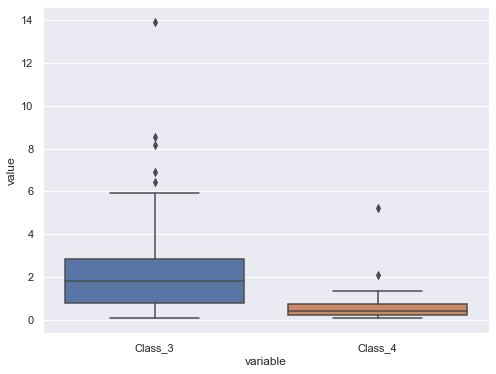

In [161]:
df = wss_eda_scaled.loc[train_split]
sns.boxplot(x="variable", y="value", data=pd.melt(df.iloc[:,6:8]))

plt.show()

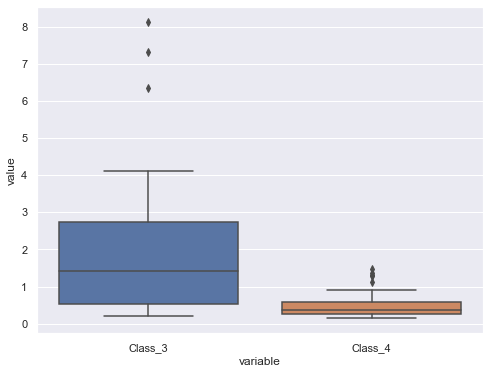

In [162]:
df = wss_eda_scaled.loc[val_split]
sns.boxplot(x="variable", y="value", data=pd.melt(df.iloc[:,6:8]))

plt.show()

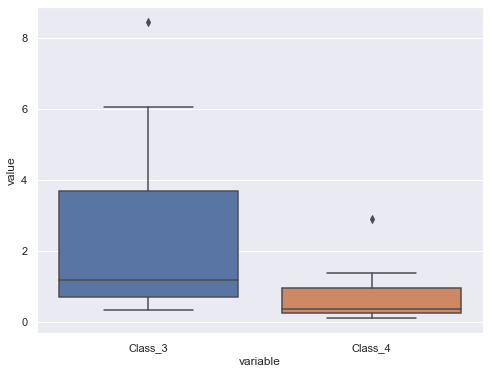

In [163]:
df = wss_eda_scaled.loc[test_split]
sns.boxplot(x="variable", y="value", data=pd.melt(df.iloc[:,6:8]))

plt.show()

### modify splits by removing additional outliers

In [176]:
outliers = (set(wss_eda_scaled.query("Class_4 > 1.31").index.values)
 .union(set(wss_eda_scaled.query("Class_3 > 6.1").index.values))
)
list(outliers)

['85_KG',
 '47_LE',
 '24_HJ',
 '125_VT',
 '7_BP',
 '64_CA',
 '70_HI',
 '131_ZK',
 '20_EM',
 '23_HJ',
 '128_WW',
 '117_TI',
 '59_SI']

In [191]:
if '131_ZK' not in list(outliers):
    print('True')

In [255]:
# Original
new_splits= {'train': ['102_OC', '27_HM', '113_SN','101_MR','48_LE','4_BC',
         '49_LE', '91_LS', '32_JM',  '67_HC','130_ZK', '55_MR','97_MD', 
         '122_TR', '124_VA', '120_TM', '31_JM','109_SG','89_LE', 
         '75_IS', '69_HI', '78_KB','73_HS', '126_WD','80_KBB','35_KBB', '30_JM',
         '26_HM', '25_HM', '118_TI','105_RS','15_TR','93_MAS','72_HRA',
         '106_RU', '123_TR', '16_TR', '61_BN', '50_LE','68_HD',
         '110_SK','111_SK','86_KI', '108_SB', '2_BC', '3_BC', '10_SUM', 
         '42_KBB','114_SR', '115_SR','41_KBB','76_JM','13_PMM','14_TR','40_KBB',
         '54_MR', '12_GAW', '9_KBW','99_MM','92_MAS', '46_LE','37_KBB','119_TI',
         '65_FU', '22_FA',  '21_FA','57_SF','88_KR','90_BMW', '34_KBB',
         '60_BL','81_KBB','58_SI',], 
  'val': ['77_KA','83_KBB', '51_LE','74_HS','1_AK', '8_BP',
          '95_MAS','79_KBB','56_WA', '66_GI', '38_KBB','94_MAS', '98_MJ',
          '36_KBB','39_KBB', '104_PH', '43_KBB', 
          '121_TR', '6_BM',
          '28_JM','62_CA','96_MAS', '52_LE', '100_MR', '44_AC',],
  'test': ['112_SM','63_CA', '82_KBB', '29_JM', '53_LS',
         '18_EM','33_KBB','71_HRA', '11_DHM','107_SA', '45_AC', '129_ZK' ]
  }

In [260]:
[len(v) for k,v in new_splits.items()]

[73, 25, 12]

In [256]:
train_split = set(new_splits['train']).intersection(set(wss_eda_scaled.index.values))
val_split = set(new_splits['val']).intersection(set(wss_eda_scaled.index.values))
test_split = set(new_splits['test']).intersection(set(wss_eda_scaled.index.values))


In [222]:
df = wss_eda_scaled.loc[train_split].query("Class_4 >1.0")
df

,original_points,sampled_points,down_percent,Class_0,Class_1,Class_2,Class_3,Class_4
9_KBW,79622,15393,19.3326,40.6548,36.1073,17.4755,4.7164,1.0394
119_TI,80861,15406,19.0524,47.5983,37.2777,11.3787,2.6224,1.1164
61_BN,65247,15144,23.2103,85.4464,7.8381,3.0573,2.5489,1.0961
121_TR,60383,15454,25.5933,61.9451,26.3298,7.6485,2.8601,1.2100
19_EM,82151,15357,18.6936,51.5856,29.2375,12.0987,5.7824,1.2893
124_VA,45344,15311,33.7663,43.3610,26.1707,25.6678,3.7555,1.0319
6_BM,20744,15154,73.0524,70.1135,16.6887,9.4431,2.6000,1.1482


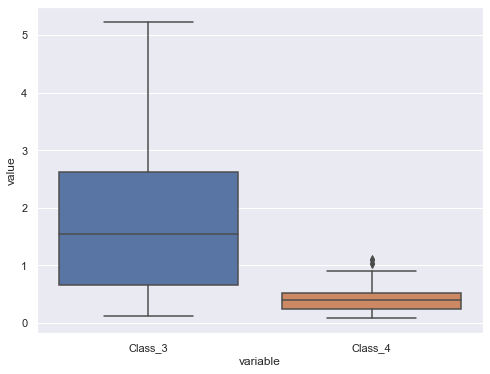

In [257]:
df = wss_eda_scaled.loc[train_split]
sns.boxplot(x="variable", y="value", data=pd.melt(df.iloc[:,6:8]))

plt.show()

In [212]:
df = wss_eda_scaled.loc[train_split]
df.query("Class_4 >1.05").index.values

array(['119_TI', '61_BN', '121_TR', '19_EM', '6_BM'], dtype=object)

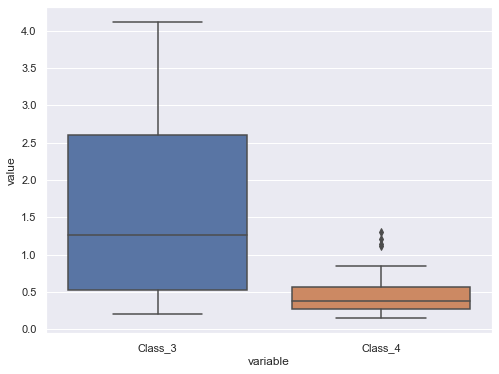

In [258]:
df = wss_eda_scaled.loc[val_split]
sns.boxplot(x="variable", y="value", data=pd.melt(df.iloc[:,6:8]))

plt.show()

In [230]:
df = wss_eda_scaled.loc[val_split]
df.query("Class_4 >0.6").index.values

array(['96_MAS', '104_PH', '74_HS'], dtype=object)

In [232]:
df = wss_eda_scaled.loc[val_split]
df

,original_points,sampled_points,down_percent,Class_0,Class_1,Class_2,Class_3,Class_4
98_MJ,61595,15378,24.9663,77.2077,20.3407,1.5152,0.6568,0.2731
81_KBB,100143,15279,15.2572,91.0793,7.1274,1.1323,0.5170,0.1374
83_KBB,45616,15257,33.4466,71.6458,17.3953,8.7632,1.8680,0.3212
56_WA,74075,15252,20.5899,73.3412,24.1083,1.7965,0.5245,0.2229
77_KA,42028,15215,36.2021,90.3911,6.0730,2.4844,0.6770,0.3681
96_MAS,42000,15200,36.1905,42.7039,40.7500,12.5592,2.8684,1.1118
104_PH,77763,15262,19.6263,73.7125,14.2314,7.3385,3.4137,1.2973
38_KBB,52046,15300,29.3971,47.8366,37.7843,10.0719,3.7386,0.5621
58_SI,63579,15326,24.1054,65.9402,27.2870,5.7941,0.5807,0.3915
51_LE,45491,15208,33.4308,55.4511,28.2943,11.5531,4.1163,0.5786


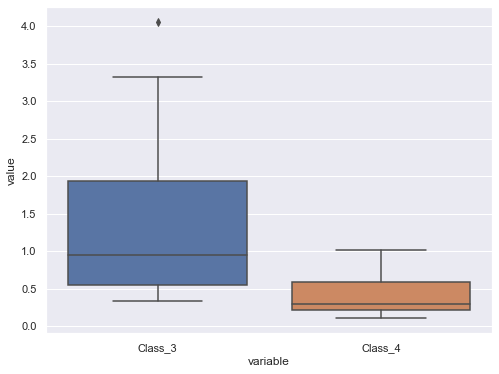

In [259]:
df = wss_eda_scaled.loc[test_split]
sns.boxplot(x="variable", y="value", data=pd.melt(df.iloc[:,6:8]))

plt.show()

In [244]:
df = wss_eda_scaled.loc[test_split]
df

,original_points,sampled_points,down_percent,Class_0,Class_1,Class_2,Class_3,Class_4
53_LS,111847,15273,13.6553,75.8201,19.3282,3.8958,0.5827,0.3601
82_KBB,44884,15259,33.9965,47.9717,42.1522,7.4186,1.8874,0.5570
112_SM,86051,15266,17.7406,69.6581,17.8960,9.3148,2.1027,1.0219
63_CA,40064,15247,38.0566,74.1457,21.4534,3.8631,0.3411,0.1771
29_JM,70799,15339,21.6656,45.0616,36.9907,13.1690,4.0550,0.7171
87_KJ,54910,15366,27.9840,41.9498,34.9213,16.0289,6.0588,1.0348
33_KBB,76973,15323,19.9070,61.5284,32.7025,4.4965,0.9985,0.2610
129_ZK,103788,15334,14.7743,68.0840,23.7055,6.9649,0.9065,0.3326
11_DHM,76754,15304,19.9390,83.2985,14.8981,1.1827,0.4639,0.1503
18_EM,64337,15175,23.5867,58.0692,25.8451,11.8682,3.3213,0.8830


In [42]:

PATIENT_ID = '87_KJ'
#LOAD Point Cloud in o3d instance
pc_original = o3d.io.read_point_cloud(os.path.join(INPUT_PATH,f"{PATIENT_ID}{ORIGINAL_FILENAME}"))
pc_o3d = o3d.io.read_point_cloud(os.path.join(OUTPUT_TEMP_PATH,f"{PATIENT_ID}{PYMESH_FILENAME}"))

#Compute nearest distance
NN_dist = pc_o3d.compute_nearest_neighbor_distance()
np.array(NN_dist)

array([7.07767669e-05, 1.11411225e-04, 8.08090068e-05, ...,
       7.97237394e-05, 7.49280083e-05, 8.72974148e-05])

In [43]:
np.argmin(np.array(NN_dist))

15341

In [48]:
len(NN_dist)

15366

In [44]:
np.array(NN_dist)

array([7.07767669e-05, 1.11411225e-04, 8.08090068e-05, ...,
       7.97237394e-05, 7.49280083e-05, 8.72974148e-05])

In [45]:
np.array(pc_o3d.points[0:2])

array([[ 0.0250287 , -0.17320925, -0.13580781],
       [ 0.02493183, -0.17314373, -0.13578936]])

In [46]:
pc_o3d.points[np.argmin(np.array(NN_dist))]

array([ 0.02455576, -0.17057672, -0.12956147])

In [47]:
NN_dist1 = pc_original.compute_nearest_neighbor_distance()
np.array(NN_dist1)

array([4.66313683e-05, 4.66313683e-05, 4.85598065e-05, ...,
       5.11429740e-05, 4.74073380e-05, 5.41228045e-05])

In [30]:
np.array(pc_original.points)

array([[ 0.02498287, -0.17321751, -0.13580844],
       [ 0.02495572, -0.1731808 , -0.13579892],
       [ 0.02498408, -0.17314193, -0.1357924 ],
       ...,
       [ 0.02462352, -0.17025369, -0.12967546],
       [ 0.0246368 , -0.17030613, -0.12966052],
       [ 0.02463477, -0.17019865, -0.12969047]])

# 2 Check Radius for downsampled files

In [20]:
# del(radius_df)
radius_columns = ['original_points','sampled_points','radius_mean','radius_median','radius_std','radius_min','radius_max',]
radius_df = pd.DataFrame(index=patient_id_list, columns = radius_columns )
radius_df.head(2)

,original_points,sampled_points,radius_mean,radius_median,radius_std,radius_min,radius_max
2_BC,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3_BC,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
for PATIENT_ID in patient_id_list:

    #LOAD Point Cloud in o3d instance
    pc_original = o3d.io.read_point_cloud(os.path.join(INPUT_PATH,f"{PATIENT_ID}{ORIGINAL_FILENAME}"))
    pc_o3d = o3d.io.read_point_cloud(os.path.join(OUTPUT_TEMP_PATH,f"{PATIENT_ID}{PYMESH_FILENAME}"))

    #Compute nearest distance
    NN_dist = pc_o3d.compute_nearest_neighbor_distance()
    
    radius_df.loc[PATIENT_ID] = [len(np.asarray(pc_original.points)),len(np.asarray(pc_o3d.points)), 
                          np.mean(NN_dist), np.median(NN_dist), np.std(NN_dist), np.min(NN_dist), np.max(NN_dist)
                         ]

# df = df.astype(float)
radius_df = radius_df.infer_objects()
# pd.to_numeric(df, downcast='float')
radius_df.head(5)

,original_points,sampled_points,radius_mean,radius_median,radius_std,radius_min,radius_max
2_BC,77127,15307,0.000114,0.000114,0.000026,0.000011,0.000245
3_BC,28274,15271,0.000119,0.000117,0.000026,0.000014,0.000244
4_BC,22604,15223,0.000110,0.000103,0.000019,0.000030,0.000222
5_BM,95358,15366,0.000176,0.000173,0.000057,0.000033,0.000480
6_BM,20744,15154,0.000087,0.000084,0.000017,0.000033,0.000179


In [22]:
radius_df.describe(percentiles = np.arange(0,1.1,0.1))

,original_points,sampled_points,radius_mean,radius_median,radius_std,radius_min,radius_max
count,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000
mean,66639.869231,15306.069231,0.000095,0.000094,0.000025,0.000021,0.000233
std,22043.015602,94.365871,0.000022,0.000021,0.000006,0.000009,0.000055
min,20744.000000,15112.000000,0.000054,0.000053,0.000013,0.000002,0.000133
0%,20744.000000,15112.000000,0.000054,0.000053,0.000013,0.000002,0.000133
10%,41880.600000,15174.900000,0.000073,0.000072,0.000019,0.000009,0.000179
20%,48223.600000,15238.000000,0.000079,0.000078,0.000020,0.000013,0.000191
30%,55788.300000,15265.700000,0.000084,0.000083,0.000022,0.000016,0.000203
40%,60633.200000,15278.600000,0.000087,0.000086,0.000023,0.000018,0.000212
50%,65068.500000,15301.000000,0.000091,0.000090,0.000024,0.000020,0.000224


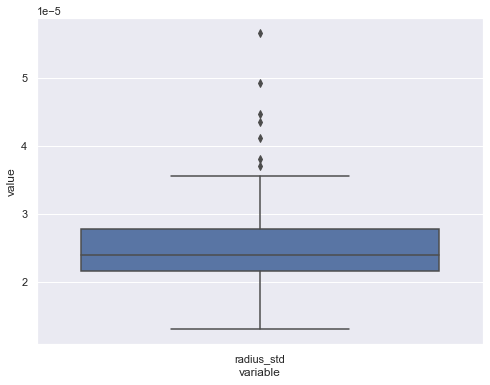

In [24]:
sns.boxplot(x="variable", y="value", data=pd.melt(radius_df.iloc[:,4:5]))

plt.show()

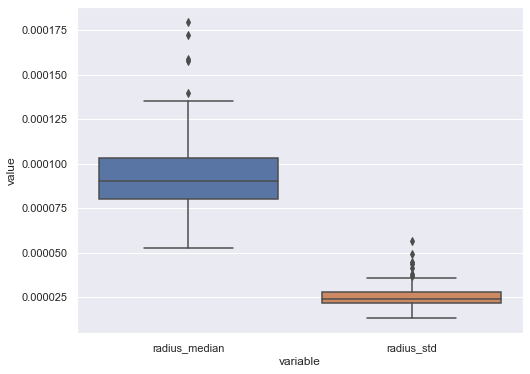

In [26]:
sns.boxplot(x="variable", y="value", data=pd.melt(radius_df.iloc[:,3:5]))

plt.show()

In [27]:
#OUTLIERS
radius_df.query("radius_std >0.000036 and radius_median > 0.000135").index.values

array(['5_BM', '84_KE', '103_PA', '116_SR', '127_WW'], dtype=object)

In [39]:
patient_id_list_new = list(set(patient_id_list).difference(set(['5_BM', '84_KE', '103_PA', '116_SR', '127_WW'])))
len(patient_id_list_new)

125

In [40]:
patient_id_list_new

['7_BP',
 '9_KBW',
 '101_MR',
 '112_SM',
 '37_KBB',
 '13_PMM',
 '40_KBB',
 '16_TR',
 '78_KB',
 '118_TI',
 '61_BN',
 '83_KBB',
 '124_VA',
 '90_BMW',
 '107_SA',
 '94_MAS',
 '76_JM',
 '96_MAS',
 '46_LE',
 '60_BL',
 '10_SUM',
 '117_TI',
 '123_TR',
 '8_BP',
 '73_HS',
 '43_KBB',
 '82_KBB',
 '114_SR',
 '105_RS',
 '88_KR',
 '59_SI',
 '130_ZK',
 '27_HM',
 '55_MR',
 '24_HJ',
 '63_CA',
 '25_HM',
 '21_FA',
 '62_CA',
 '115_SR',
 '64_CA',
 '15_TR',
 '69_HI',
 '39_KBB',
 '22_FA',
 '104_PH',
 '95_MAS',
 '1_AK',
 '70_HI',
 '93_MAS',
 '51_LE',
 '71_HRA',
 '57_SF',
 '30_JM',
 '58_SI',
 '54_MR',
 '119_TI',
 '47_LE',
 '108_SB',
 '67_HC',
 '98_MJ',
 '48_LE',
 '125_VT',
 '18_EM',
 '3_BC',
 '49_LE',
 '2_BC',
 '92_MAS',
 '45_AC',
 '66_GI',
 '121_TR',
 '20_EM',
 '109_SG',
 '34_KBB',
 '86_KI',
 '50_LE',
 '6_BM',
 '113_SN',
 '87_KJ',
 '14_TR',
 '42_KBB',
 '111_SK',
 '97_MD',
 '77_KA',
 '120_TM',
 '12_GAW',
 '131_ZK',
 '68_HD',
 '102_OC',
 '23_HJ',
 '33_KBB',
 '79_KBB',
 '128_WW',
 '52_LE',
 '99_MM',
 '126_WD',
 '

In [44]:
radius_df_new = radius_df[radius_df.index.isin(patient_id_list_new)] 
radius_df_new.shape

(125, 7)

In [45]:
np.round(radius_df_new.radius_std*1000000,0).sort_values()

131_ZK    13.0
128_WW    14.0
112_SM    16.0
102_OC    17.0
27_HM     17.0
6_BM      17.0
77_KA     17.0
85_KG     18.0
113_SN    18.0
101_MR    18.0
48_LE     18.0
4_BC      19.0
83_KBB    19.0
49_LE     19.0
91_LS     19.0
32_JM     19.0
63_CA     19.0
67_HC     19.0
130_ZK    20.0
70_HI     20.0
51_LE     20.0
55_MR     20.0
97_MD     20.0
122_TR    20.0
124_VA    20.0
120_TM    20.0
82_KBB    20.0
31_JM     21.0
7_BP      21.0
74_HS     21.0
87_KJ     21.0
109_SG    21.0
89_LE     21.0
1_AK      22.0
29_JM     22.0
47_LE     22.0
53_LS     22.0
75_IS     22.0
69_HI     22.0
78_KB     22.0
117_TI    22.0
73_HS     23.0
126_WD    23.0
8_BP      23.0
28_JM     23.0
80_KBB    23.0
62_CA     23.0
60_BL     23.0
35_KBB    23.0
30_JM     23.0
26_HM     23.0
25_HM     23.0
118_TI    23.0
105_RS    23.0
15_TR     23.0
96_MAS    23.0
95_MAS    23.0
93_MAS    24.0
72_HRA    24.0
121_TR    24.0
125_VT    24.0
79_KBB    24.0
23_HJ     24.0
106_RU    24.0
123_TR    24.0
16_TR     24.0
61_BN     

In [59]:
np.round(radius_df_new.radius_std*1000000,0).sort_values().index[100:]

Index(['54_MR', '12_GAW', '9_KBW', '36_KBB', '107_SA', '99_MM', '92_MAS',
       '46_LE', '37_KBB', '119_TI', '20_EM', '65_FU', '22_FA', '19_EM',
       '39_KBB', '21_FA', '57_SF', '104_PH', '88_KR', '43_KBB', '45_AC',
       '90_BMW', '34_KBB', '81_KBB', '129_ZK'],
      dtype='object')

In [ ]:
{'train': ['131_ZK', '102_OC', '27_HM', '6_BM','113_SN','101_MR','48_LE','4_BC',
         '49_LE', '91_LS', '32_JM',  '67_HC','130_ZK', '70_HI', '55_MR','97_MD', 
         '122_TR', '124_VA', '120_TM', '31_JM', '7_BP','109_SG','89_LE','47_LE', 
         '75_IS', '69_HI', '78_KB','73_HS', '126_WD','80_KBB','35_KBB', '30_JM',
         '26_HM', '25_HM', '118_TI','105_RS','15_TR','93_MAS','72_HRA','121_TR', 
         '23_HJ', '106_RU', '123_TR', '16_TR', '61_BN', '50_LE','24_HJ','68_HD',
         '110_SK', '64_CA','111_SK','86_KI', '108_SB', '2_BC', '3_BC', '10_SUM', 
         '42_KBB','114_SR', '115_SR','41_KBB','76_JM','13_PMM','14_TR','40_KBB',
         '54_MR', '12_GAW', '9_KBW','99_MM','92_MAS', '46_LE','37_KBB','119_TI',
         '65_FU', '22_FA', '19_EM', '21_FA','57_SF','88_KR','90_BMW', '34_KBB'], 
  'val': ['128_WW','77_KA','83_KBB', '51_LE','74_HS','1_AK', '8_BP','60_BL',
          '95_MAS','79_KBB','59_SI','56_WA', '66_GI', '38_KBB','94_MAS', '98_MJ',
          '36_KBB', '20_EM','39_KBB', '104_PH', '43_KBB', '81_KBB'],
  'test': ['112_SM','85_KG','63_CA', '82_KBB', '87_KJ','29_JM', '53_LS','117_TI',
         '28_JM','62_CA','96_MAS', '125_VT', '58_SI', '52_LE', '100_MR', '44_AC',
         '18_EM','33_KBB','71_HRA', '11_DHM','107_SA', '45_AC', '129_ZK' ]
  }

In [66]:
x ={'train': ['131_ZK','102_OC','27_HM','6_BM','113_SN','101_MR','48_LE','4_BC',
         '49_LE', '91_LS', '32_JM',  '67_HC','130_ZK', '70_HI', '55_MR','97_MD', 
         '122_TR', '124_VA', '120_TM', '31_JM', '7_BP','109_SG','89_LE','47_LE', 
         '75_IS', '69_HI', '78_KB','73_HS', '126_WD','80_KBB','35_KBB', '30_JM',
         '26_HM', '25_HM', '118_TI','105_RS','15_TR','93_MAS','72_HRA','121_TR', 
         '23_HJ', '106_RU', '123_TR', '16_TR', '61_BN', '50_LE','24_HJ','68_HD',
         '110_SK', '64_CA','111_SK','86_KI', '108_SB', '2_BC', '3_BC', '10_SUM', 
         '42_KBB','114_SR', '115_SR','41_KBB','76_JM','13_PMM','14_TR','40_KBB',
         '54_MR', '12_GAW', '9_KBW','99_MM','92_MAS', '46_LE','37_KBB','119_TI',
         '65_FU', '22_FA', '19_EM', '21_FA','57_SF','88_KR','90_BMW', '34_KBB'], 
  'val': ['128_WW','77_KA','83_KBB', '51_LE','74_HS','1_AK', '8_BP','60_BL',
          '95_MAS','79_KBB','59_SI','56_WA', '66_GI', '38_KBB','94_MAS', '98_MJ',
          '36_KBB', '20_EM','39_KBB', '104_PH', '43_KBB', '81_KBB'],
  'test': ['112_SM','85_KG','63_CA', '82_KBB', '87_KJ','29_JM', '53_LS','117_TI',
         '28_JM','62_CA','96_MAS', '125_VT', '58_SI', '52_LE', '100_MR', '44_AC',
         '18_EM','33_KBB','71_HRA', '11_DHM','107_SA', '45_AC', '129_ZK' ]
  }

In [67]:
[len(v) for k,v in x.items()]

[81, 22, 22]

In [63]:
all_files = {'131_ZK', '102_OC', '27_HM', '6_BM','113_SN', '101_MR','48_LE', '4_BC',
         '49_LE', '91_LS', '32_JM',  '67_HC','130_ZK', '70_HI', '55_MR','97_MD', 
         '122_TR', '124_VA', '120_TM', '31_JM', '7_BP','109_SG','89_LE','47_LE', 
         '75_IS', '69_HI', '78_KB','73_HS', '126_WD','80_KBB','35_KBB', '30_JM',
         '26_HM', '25_HM', '118_TI', '105_RS','15_TR', '93_MAS', '72_HRA','121_TR', 
         '23_HJ', '106_RU','123_TR', '16_TR', '61_BN', '50_LE','24_HJ','68_HD',
         '110_SK', '64_CA','111_SK', '86_KI', '108_SB', '2_BC', '3_BC', '10_SUM', 
         '42_KBB','114_SR', '115_SR', '41_KBB', '76_JM', '13_PMM', '14_TR','40_KBB'
         '54_MR', '12_GAW', '9_KBW', '99_MM', '92_MAS', '46_LE','37_KBB','119_TI',
         '65_FU','22_FA', '19_EM','21_FA', '57_SF','88_KR', '45_AC','90_BMW', 
         '34_KBB','128_WW','77_KA','83_KBB', '51_LE','74_HS','1_AK', '8_BP','60_BL',
        '95_MAS','79_KBB','59_SI','56_WA', '66_GI', '38_KBB','94_MAS', '98_MJ',
        '36_KBB', '20_EM','39_KBB', '104_PH', '43_KBB', '81_KBB', '112_SM','85_KG',
        '63_CA', '82_KBB', '87_KJ','29_JM', '53_LS','117_TI',
         '28_JM','62_CA','96_MAS', '125_VT','58_SI', '52_LE', '100_MR', '44_AC',
         '18_EM','33_KBB','71_HRA',  '11_DHM','107_SA', '129_ZK' 
  }

In [65]:
all_files.difference(set(radius_df_new.index))

{'40_KBB54_MR'}

In [62]:
len(np.round(radius_df_new.radius_min*1000000,0).sort_values().index)

125

In [64]:
[{k:sorted(v)} for k,v in x.items()]


[{'train': ['10_SUM',
   '11_DHM',
   '12_GAW',
   '13_PMM',
   '14_TR',
   '18_EM',
   '19_EM',
   '21_FA',
   '22_FA',
   '25_HM',
   '26_HM',
   '27_HM',
   '2_BC',
   '30_JM',
   '31_JM',
   '34_KBB',
   '35_KBB',
   '36_KBB',
   '37_KBB',
   '38_KBB',
   '39_KBB',
   '3_BC',
   '40_KBB',
   '41_KBB',
   '42_KBB',
   '44_AC',
   '45_AC',
   '46_LE',
   '47_LE',
   '50_LE',
   '51_LE',
   '52_LE',
   '54_MR',
   '55_MR',
   '56_WA',
   '57_SF',
   '58_SI',
   '59_SI',
   '5_BM',
   '7_BP',
   '9_KBW']},
 {'val': ['15_TR',
   '16_TR',
   '23_HJ',
   '24_HJ',
   '29_JM',
   '33_KBB',
   '43_KBB',
   '48_LE',
   '4_BC',
   '8_BP']},
 {'test': ['15_TR', '20_EM', '28_JM', '32_JM', '6_BM']}]